In [19]:
import cv2

mp4_path = '../SaveVideo.mp4'
cap = cv2.VideoCapture(mp4_path)

frame_list = []
i=0
while(cap.isOpened()):
    i+=1
    ret, frame = cap.read()
    frame_list.append(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if i==300:
        break

In [20]:
frame_list = frame_list[100:300]

In [21]:
import numpy as np

frames = np.array(frame_list)

In [22]:
frames[:,:,:,0], frames[:,:,:,2] = frames[:,:,:,2], frames[:,:,:,0]

In [23]:
frames.shape

(200, 480, 640, 3)

In [6]:
import matplotlib.pyplot as plt

In [7]:
def pool(img, factor=2):
    img0 = max_pool(img[:,:,0],factor=2)
    img1 = max_pool(img[:,:,1],factor=2)
    img2 = max_pool(img[:,:,2],factor=2)
    img = np.stack([img0, img1, img2]).swapaxes(0,2)
    img = img.swapaxes(0,1)
    return img

def max_pool(img, factor: int):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

In [8]:
pool_imgs = []
for frame in frames:
    pool_imgs.append(pool(pool(pool(frame))))

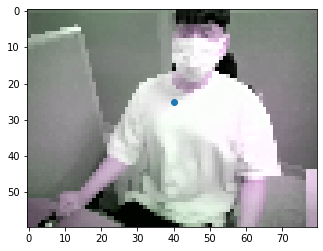

In [9]:
plt.scatter(40,25)
plt.imshow(pool_imgs[0])

In [10]:
def calc_rect_by_point(width, height):
    min_width = width*8-4
    max_width = width*8+4
    min_height = height*8-4
    max_height = height*8+4
    return (min_width, min_height), (max_width, max_height)

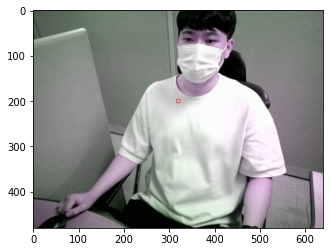

In [11]:
rect = calc_rect_by_point(40,25)
rected_img = cv2.rectangle(frame, rect[0], rect[1], (255,0,0), 1)
plt.imshow(rected_img)

In [29]:
one = np.ones((8,8,3))
print(one.shape)
pool(pool(pool(one))).shape

(8, 8, 3)


(1, 1, 3)

In [15]:
pool_imgs = np.array(pool_imgs)
mean_pool_imgs = pool_imgs.mean(axis=3)
mean_pool_imgs = np.array(mean_pool_imgs)

In [15]:
plt.imshow(frame)

: 

: 

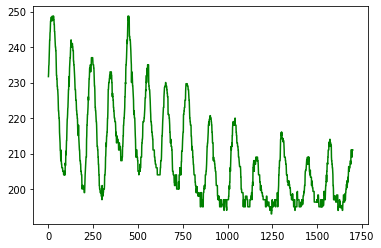

In [94]:
point = mean_pool_imgs[:,25,40] #25,40
plt.plot(point, color='green')

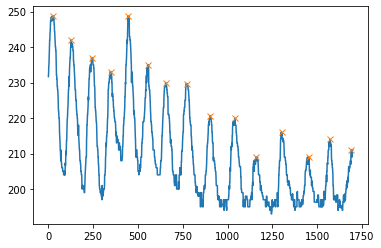

In [204]:
from scipy.signal import find_peaks

peaks, properties = find_peaks(point, distance=100)

plt.plot(point)
plt.plot(peaks, point[peaks], "x")

In [31]:
# np.sum(max_pool(frame[:,:,0], 8)-max_pool(max_pool(max_pool(frame[:,:,0], 2),2),2))
# max_pool(frame[:,:,0], 8)
# max_pool(max_pool(max_pool(frame[:,:,0], 2),2),2)

array([[112, 114, 117, ..., 138, 134, 136],
       [109, 108, 113, ..., 140, 136, 134],
       [105, 113, 113, ..., 139, 137, 136],
       ...,
       [ 52,  56,  54, ..., 143, 142, 135],
       [ 49,  51,  58, ..., 145, 138, 132],
       [ 47,  59,  61, ..., 143, 135, 129]], dtype=uint8)

In [5]:
from scipy.signal import find_peaks
import cv2
import numpy as np

def pool(img, factor=8):
    return max_pool(img,factor)

def max_pool(img, factor: int):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

def calc_brpm(point):
    peaks, _ = find_peaks(point[-1200:], distance=100)
    num_of_peaks = len(peaks)
    if len(point) < 1200:
        ratio = 1200/len(point)
        num_of_peaks *= ratio
        num_of_peaks = round(num_of_peaks)
    return num_of_peaks

def calc_rect_by_point(width, height):
    min_width = width*8-4
    max_width = width*8+4
    min_height = height*8-4
    max_height = height*8+4
    return (min_width, min_height), (max_width, max_height)

In [9]:
import cv2
import numpy as np
import sys
import io

def VideoWrite():
    try:
        print("카메라 구동")
        # cap = cv2.VideoCapture(0)
        mp4_path = '../SaveVideo.mp4'
        cap = cv2.VideoCapture(mp4_path)
    except:
        print("카메라 구동실패")
        return

    width = int(cap.get(3))
    height = int(cap.get(4))

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    out = cv2.VideoWriter('SaveVideo_BrPM.mp4',fourcc,20.0,(width, height))
    
    point_list = []

    # 폰트 색상 지정
    blue = (255, 0, 0)
    green= (0, 255, 0)
    red= (0, 0, 255)
    white= (255, 255, 255) 
    # 폰트 지정
    font =  cv2.FONT_HERSHEY_PLAIN

    while(True):
        ret, frame = cap.read()

        if not ret:
            print("비디오 읽기 오류")
            break
        
        gray = cv2.cvtColor(frame,  cv2.COLOR_BGR2GRAY)
        new_frame = pool(gray)
        point_width = 40 #40
        point_height = 25 #50
        point = new_frame[point_height, point_width]
        rect = calc_rect_by_point(point_width, point_height)
        point_list.append(point)
        
        frame = cv2.rectangle(frame, rect[0], rect[1], blue, 1)
        frame = cv2.putText(frame, str(point), (300, 190), font, 2, blue, 1, cv2.LINE_AA)
        if len(point_list)>100:
            brpm = calc_brpm(point_list)
            frame = cv2.putText(frame, str(brpm)+' brpm', (500, 400), font, 2, red, 1, cv2.LINE_AA)
        # cv2.imshow('video',frame)
        out.write(frame)

        k= cv2.waitKey(1)
        if(k == 27):
            print('녹화 종료')
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

VideoWrite()

카메라 구동


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


비디오 읽기 오류
